Install các thư viện

In [2]:
!pip install numpy opencv-python-headless plotly Pillow matplotlib gdown numba


Thêm các thư viện

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import numba as nb

# **1. Thuật Toán Xoay Ảnh 2D**

In [4]:
class ImageRotation2D:
    def __init__(self, image: np.ndarray):
        """
        Khởi tạo đối tượng xoay ảnh màu 2D.

        :param image: Ảnh đầu vào dạng numpy array 3 chiều (H x W x C).
        """
        self.image = image
        self.height, self.width, self.channels = image.shape
        self.xc = (self.height - 1) / 2
        self.yc = (self.width - 1) / 2

    def rotation_matrix(self, angle_rad: float) -> np.ndarray:
        """
        Trả về ma trận xoay 2D Givens theo góc radian.

        :param angle_rad: Góc xoay tính bằng radian.
        :return: Ma trận xoay 2x2.
        """
        cos_a = np.cos(angle_rad)
        sin_a = np.sin(angle_rad)
        return np.array([
            [cos_a, -sin_a],
            [sin_a,  cos_a]
        ])

    def rotate(self, angle_degrees: float, background_color=(255, 255, 255)) -> np.ndarray:
        """
        Xoay ảnh màu bằng ánh xạ ngược với góc xoay tùy chọn.

        :param angle_degrees: Góc xoay theo độ (dương là xoay ngược chiều kim đồng hồ).
        :param background_color: Tuple RGB cho màu nền (mặc định: trắng).
        :return: Ảnh đã xoay.
        """
        angle_rad = np.deg2rad(angle_degrees)
        R = self.rotation_matrix(angle_rad)

        # Tính kích thước ảnh mới sau khi xoay
        corners = np.array([
            [ self.xc,  self.yc],
            [-self.xc, -self.yc],
            [-self.xc,  self.yc],
            [ self.xc, -self.yc]
        ])
        rotated_corners = (R @ corners.T).T
        x_bounds, y_bounds = rotated_corners[:, 0], rotated_corners[:, 1]

        new_h = int(np.ceil(x_bounds.max() - x_bounds.min()))
        new_w = int(np.ceil(y_bounds.max() - y_bounds.min()))
        x_c_new = (new_h - 1) / 2
        y_c_new = (new_w - 1) / 2

        # Tạo ảnh kết quả
        rotated = np.full((new_h, new_w, self.channels), background_color, dtype=self.image.dtype)

        # Tạo lưới tọa độ cho ảnh kết quả
        X, Y = np.meshgrid(np.arange(new_h), np.arange(new_w), indexing='ij')
        Xc = X - x_c_new
        Yc = Y - y_c_new

        coords = np.stack([Xc.flatten(), Yc.flatten()], axis=1)
        inv_coords = (self.rotation_matrix(-angle_rad) @ coords.T).T

        src_x = inv_coords[:, 0] + self.xc
        src_y = inv_coords[:, 1] + self.yc

        # Gán giá trị pixel hợp lệ
        valid = (0 <= src_x) & (src_x < self.height) & (0 <= src_y) & (src_y < self.width)
        src_x_valid = src_x[valid].astype(int)
        src_y_valid = src_y[valid].astype(int)

        rotated.reshape(-1, self.channels)[valid] = self.image[src_x_valid, src_y_valid]
        return rotated


# **2. Thuật Toán Xoay Ảnh 3D**

In [5]:
class ImageRotation3D:
    def __init__(self, image: np.ndarray):
        """
        Khởi tạo bộ xoay ảnh 3D bằng phép chiếu phối cảnh.

        :param image: Ảnh đầu vào dạng numpy array (H x W x C).
        """
        if image.ndim != 3 or image.shape[2] not in [1, 3]:
            raise ValueError("Ảnh phải có 3 chiều (H x W x C), kênh màu RGB hoặc grayscale mở rộng.")

        self.image = image
        self.height, self.width, self.channels = image.shape

        x, y = np.meshgrid(np.arange(self.height), np.arange(self.width), indexing='ij')
        z = np.zeros_like(x)
        self.pixel_coords = np.stack((x.ravel(), y.ravel(), z.ravel()), axis=1)

    def givens_rotation_matrix(self, i: int, j: int, theta: float) -> np.ndarray:
        """
        Trả về ma trận xoay Givens 3x3.

        :param i: Trục thứ nhất (0, 1, 2).
        :param j: Trục thứ hai (0, 1, 2), khác với i.
        :param theta: Góc xoay (radian).
        :return: Ma trận xoay 3x3.
        """
        if i == j or not (0 <= i <= 2 and 0 <= j <= 2):
            raise ValueError("Chỉ số trục phải khác nhau và nằm trong khoảng [0, 2].")
        if i > j:
            i, j = j, i

        G = np.eye(3)
        c, s = np.cos(theta), np.sin(theta)
        G[i, i] = c
        G[j, j] = c
        G[i, j] = s
        G[j, i] = -s
        return G

    def rotate_pixels(self, pixels, alpha, beta, gamma):
        """
        Xoay ảnh bằng ma trận Givens lần lượt theo các trục x, y, z.

        :param pixels: Tọa độ điểm ảnh gốc (N x 3).
        :param alpha: Góc xoay quanh trục x (radian).
        :param beta: Góc xoay quanh trục y (radian).
        :param gamma: Góc xoay quanh trục z (radian).
        :return: Tọa độ đã xoay (N x 3).
        """
        pixels_centered = pixels - np.mean(pixels, axis=0)
        Rx = self.givens_rotation_matrix(0, 2, alpha)
        Ry = self.givens_rotation_matrix(1, 2, beta)
        Rz = self.givens_rotation_matrix(0, 1, gamma)
        return pixels_centered @ Rx @ Ry @ Rz

    def setup_projection(self, max_angle_deg):
        """
        Khởi tạo tham số camera để chiếu phối cảnh.

        :param max_angle_deg: Góc lớn nhất trong các góc xoay (độ).
        """
        max_dim = max(self.height, self.width)
        angle_scale = 1 + max_angle_deg / 90
        self.focal_length = max_dim * 1.2 * angle_scale
        cx, cy = self.height / 2, self.width / 2
        self.camera_matrix = np.array([
            [self.focal_length, 0, cx],
            [0, self.focal_length, cy],
            [0, 0, 1]
        ], dtype=np.float32)

    def project_to_2d(self, points_3d: np.ndarray) -> np.ndarray:
        """
        Chiếu các điểm 3D xuống không gian 2D bằng phép chiếu phối cảnh.

        :param points_3d: Tọa độ các điểm sau khi xoay (N x 3).
        :return: Tọa độ 2D đã chiếu (N x 2).
        """
        tvec = np.array([0, 0, self.focal_length * 1.5], dtype=np.float32)
        points_cam = points_3d.T + tvec.reshape(3, 1)

        x = points_cam[0] / points_cam[2]
        y = points_cam[1] / points_cam[2]
        fx = self.camera_matrix[0, 0]
        cx, cy = self.camera_matrix[0, 2], self.camera_matrix[1, 2]

        u = fx * x + cx
        v = fx * y + cy

        return np.stack([u, v], axis=1)

    def rotate(self, alpha=0, beta=0, gamma=0) -> np.ndarray:
        """
        Xoay ảnh quanh các trục x, y, z và chiếu ảnh xuống mặt phẳng 2D.

        :param alpha: Góc xoay trục x (độ).
        :param beta: Góc xoay trục y (độ).
        :param gamma: Góc xoay trục z (độ).
        :return: Ảnh kết quả sau khi xoay và chiếu.
        """
        # Chuyển sang radian
        a_rad = np.deg2rad(alpha)
        b_rad = np.deg2rad(beta)
        g_rad = np.deg2rad(gamma)

        # Xoay
        rotated_pixels = self.rotate_pixels(self.pixel_coords.copy(), a_rad, b_rad, g_rad)

        # Chiếu
        self.setup_projection(max(abs(alpha), abs(beta), abs(gamma)))
        projected_2d = self.project_to_2d(rotated_pixels).astype(int)
        projected_2d -= np.min(projected_2d, axis=0)

        # Tạo ảnh đầu ra trắng
        h_out, w_out = projected_2d[:, 0].max() + 1, projected_2d[:, 1].max() + 1
        output = np.full((h_out, w_out, self.channels), 255, dtype=self.image.dtype)

        # Gán giá trị pixel
        output = assign_pixels_parallel(self.pixel_coords, projected_2d, self.image, output)
        return output


@nb.njit(parallel=True)
def assign_pixels_parallel(original_pixels, projected_pixels, source_image, output_image):
    """
    Gán pixel từ ảnh gốc sang ảnh đầu ra sau khi chiếu.

    :param original_pixels: Tọa độ gốc (N x 3).
    :param projected_pixels: Tọa độ chiếu (N x 2).
    :param source_image: Ảnh gốc.
    :param output_image: Ảnh đầu ra.
    :return: Ảnh sau khi gán.
    """
    for i in nb.prange(len(original_pixels)):
        x0, y0 = int(original_pixels[i, 0]), int(original_pixels[i, 1])
        x1, y1 = projected_pixels[i, 0], projected_pixels[i, 1]

        if source_image.ndim == 3:
            for c in range(source_image.shape[2]):
                output_image[x1, y1, c] = source_image[x0, y0, c]
        else:
            output_image[x1, y1] = source_image[x0, y0]
    return output_image


# **3. Ứng dụng**

**Tải ảnh mẫu**

In [6]:
import gdown
id = "1Acz81dy_j9kXV956N0_88gsEW8BQKVSQ"
output = "image_1.jpg"
gdown.download(id=id, output=output)
image = cv2.imread('image_1.jpg')

Downloading...
From: https://drive.google.com/uc?id=1Acz81dy_j9kXV956N0_88gsEW8BQKVSQ
To: /content/image_1.jpg
100%|██████████| 853k/853k [00:00<00:00, 7.48MB/s]


**Hàm dùng để hiển thị hình ảnh**

In [7]:
def plot_image(image,rotated_image):
  img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  rotated_rgb = cv2.cvtColor(rotated_image, cv2.COLOR_BGR2RGB)

  # Hiển thị ảnh gốc và ảnh xoay
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.imshow(img_rgb)
  plt.title('Input')
  plt.axis('off')

  plt.subplot(1, 2, 2)
  plt.imshow(rotated_rgb)
  plt.title('Output')
  plt.axis('off')

  plt.tight_layout()
  plt.show()


**Xoay ảnh 2D**

In [8]:
image_2d = ImageRotation2D(image)
rotated_image = image_2d.rotate(10)

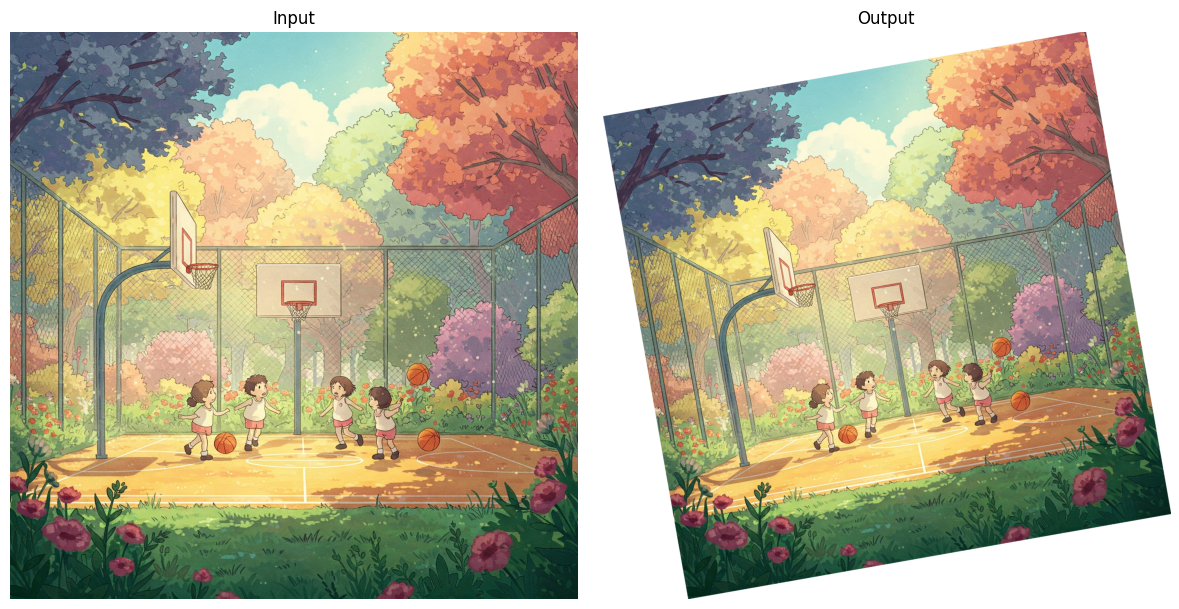

In [9]:
plot_image(image,rotated_image)

**Xoay ảnh 3D**

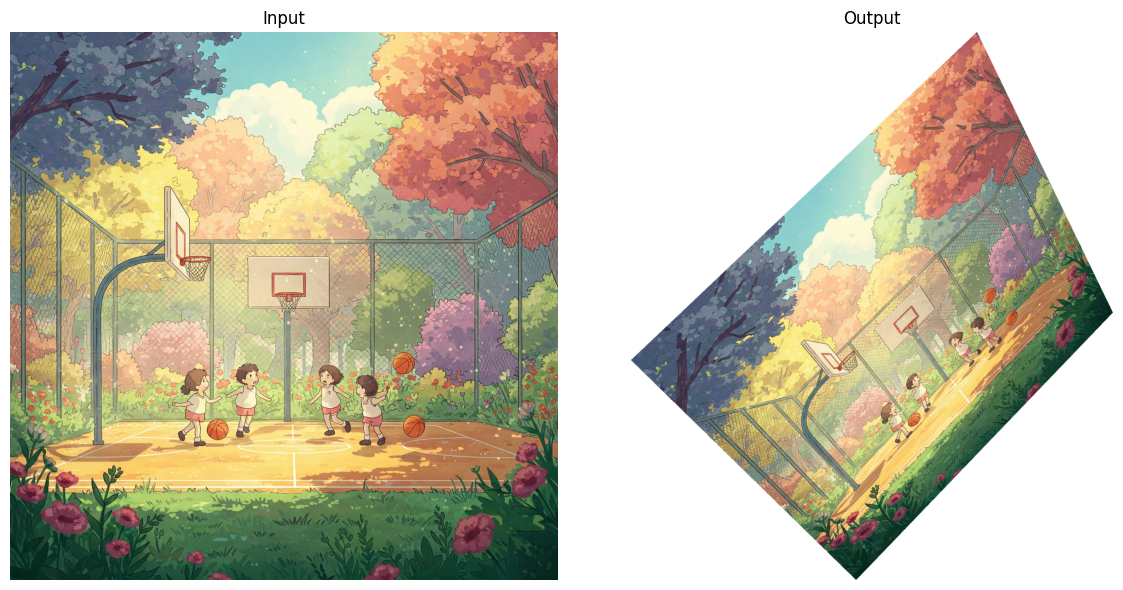

In [10]:
image_3d = ImageRotation3D(image)
rotated_image_3d = image_3d.rotate(alpha=45, beta=10, gamma=45)
plot_image(image,rotated_image_3d)

# **4. Sản phẩm app Streamlit**
* **Link app sản phẩm: https://pps-imagerotation.streamlit.app/**
* **Link Github code để deploy qua Streamlit Cloud: https://github.com/wibu1105/Image-Rotation-in-2D-3D-by-using-Rotation-Given-Matrix.git**
